In [1]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
unsw_trset, unsw_validation, y_train, y_validation = joblib.load("unsw_trv_unprocessed.pkl")
X_test, y_test = joblib.load("unsw_test_unprocessed.pkl")

X_train_val = np.concatenate([unsw_trset, unsw_validation], axis=0)
y_train_val = np.concatenate([y_train, y_validation], axis=0)
print("Training set:" + str(X_train_val.shape))

Training set:(175318, 41)


Epoch 1/150
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4014 - mae: 0.3619 - val_loss: 0.0649 - val_mae: 0.1454 - learning_rate: 0.0010
Epoch 2/150
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1828 - mae: 0.2474 - val_loss: 0.0534 - val_mae: 0.1326 - learning_rate: 0.0010
Epoch 3/150
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1664 - mae: 0.2362 - val_loss: 0.0458 - val_mae: 0.1276 - learning_rate: 0.0010
Epoch 4/150
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1576 - mae: 0.2302 - val_loss: 0.0430 - val_mae: 0.1178 - learning_rate: 0.0010
Epoch 5/150
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1541 - mae: 0.2272 - val_loss: 0.0401 - val_mae: 0.1138 - learning_rate: 0.0010
Epoch 6/150
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1514 - mae: 0.2259 - val_loss: 0.0406 - val_mae: 0.1164 - learning_rate: 0.0010
Epoch 7/150
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1487 - mae: 0.2244 - val_loss: 0.0372 - val_mae: 0.1114 - learnin

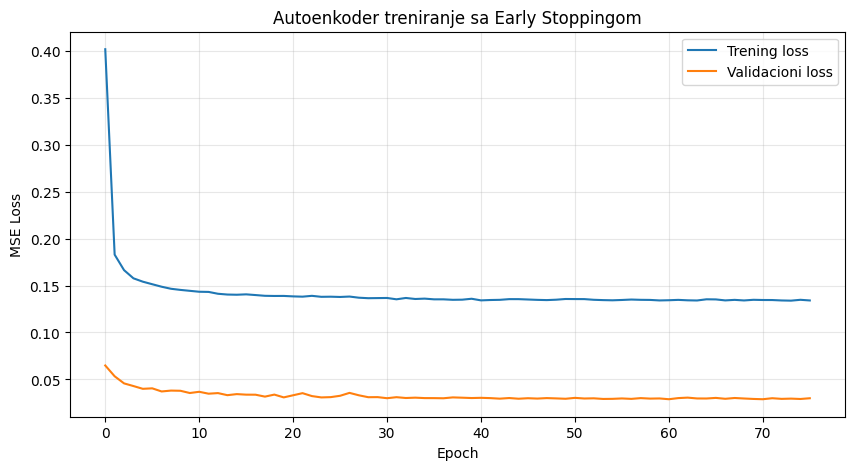

5479/5479 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Originalne dimenzije: (175318, 41)
Redukovane dimenzije: (175318, 20)


In [ ]:
#arhitektura i treniranje autoenkodera

input_dim = 41
encoding_dim = 20

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)

bottleneck = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(bottleneck)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.2)(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

history = autoencoder.fit(
    X_train_val, X_train_val,
    epochs=150,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Trening loss')
plt.plot(history.history['val_loss'], label='Validacioni loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoenkoder treniranje sa Early Stoppingom')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#redukcija dimenzionalnosti
encoder = Model(inputs=input_layer, outputs=bottleneck)
X_train_reduced = encoder.predict(X_train_val)
X_test_reduced = encoder.predict(X_test)

print(f"Originalne dimenzije: {X_train_val.shape}")
print(f"Redukovane dimenzije: {X_train_reduced.shape}")

In [8]:
joblib.dump((X_train_reduced, y_train_val), "new_unsw_train_reduced_autoenc.pkl")
joblib.dump((X_test_reduced, y_test), "new_unsw_test_reduced_autoenc.pkl")


['new_unsw_test_reduced_autoenc.pkl']